In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

tf.random.set_seed(42)

import random
random.seed(42)
import numpy as np
np.random.seed(42)

2022-05-28 21:52:31.241649: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
from pandas_ods_reader import read_ods

df = read_ods('Biogas data.ods', 'Sheet1')

In [3]:
num = df._get_numeric_data()

In [4]:
x = num.iloc[:, :]

y = num.iloc[:, -1]

In [5]:
from sklearn.preprocessing import StandardScaler

scaler_vae = StandardScaler()

x_full_scaled = scaler_vae.fit_transform(x)

In [6]:
print(x_full_scaled)

[[-1.38240012 -0.90798538 -0.90900974  1.45070271  0.31622777 -0.23325717]
 [-0.31992351  0.51000078  0.51131798  1.89299012  0.31622777 -0.25700507]
 [-1.26434716 -0.84366537 -0.84321799  1.89299012  0.31622777 -0.15937481]
 [ 0.27771958  0.35176828  0.35264376  0.87572907 -1.26491106  0.29447399]
 [ 0.24082803 -0.54820918 -0.54909018 -0.4953619  -0.47434165  0.81956649]
 [ 0.5212038   0.30564283  0.30620253  0.07961173 -0.47434165  3.0993651 ]
 [ 0.61712183  0.50054329  0.49970767  0.52189914  0.31622777  3.02548274]
 [-1.21269899 -1.10845005 -1.10638498  0.43344166  0.31622777  0.72985219]
 [ 2.10016209 -1.61220308 -1.61336844 -3.41445881  0.31622777 -0.07493782]
 [ 2.68304856  2.48904564  2.48894049 -0.22998945  1.10679718 -0.32297147]
 [ 0.68352662  1.80070272  1.8000622   0.65458537  0.31622777 -0.84278666]
 [-1.02824125 -0.98227494 -0.98254169 -0.18576071  1.10679718 -0.67655135]
 [ 0.81633619  1.14967663  1.14988494 -0.45113316  1.8973666  -0.79001355]
 [-1.10940265 -0.67365974

# Variational Autoencoder

In [7]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var), mean=0.1, stddev=0.055) * K.exp(log_var / 2) + mean

sample_size = x_full_scaled.shape[:][1]
    
K=keras.backend
keras.backend.clear_session()
latent_dim = 5
inputs = keras.layers.Input(shape=[sample_size])

z = keras.layers.Dense(256, activation='relu')(inputs)
z = keras.layers.Dropout(0.2)(z)
z = keras.layers.Dense(128, activation='relu')(z)
z = keras.layers.Dropout(0.2)(z)
z = keras.layers.Dense(32, activation='relu')(z)
z = keras.layers.Dense(16, activation='relu')(z)

latent_mean = keras.layers.Dense(latent_dim)(z)
latent_log_var = keras.layers.Dense(latent_dim)(z)
sample = Sampling()([latent_mean, latent_log_var])
variational_encoder = keras.models.Model(
inputs=[inputs], outputs=[latent_mean, latent_log_var, sample])

decoder_inputs = keras.layers.Input(shape=[latent_dim])
x = keras.layers.Dense(16, activation='relu')(decoder_inputs)
x = keras.layers.Dense(32, activation='relu')(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(sample_size)(x)

variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])
_, _, sample = variational_encoder(inputs)
reconstructions = variational_decoder(sample)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(1 + latent_log_var - K.exp(latent_log_var) - K.square(latent_mean), axis=-1)
variational_ae.add_loss(K.mean(latent_loss)/(sample_size*1.))
variational_ae.compile(loss='mse',
                       optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=['mse'])
variational_ae.save('vae.tf', save_format='tf')

2022-05-28 21:52:34.884524: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-28 21:52:34.884949: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-28 21:52:34.884971: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-28 21:52:34.885001: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-GM3F9HH): /proc/driver/nvidia/version does not exist
2022-05-28 21:52:34.885342: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild T

INFO:tensorflow:Assets written to: vae.tf/assets


In [8]:
vae_mft = keras.models.load_model('vae.tf')
history = vae_mft.fit(x_full_scaled, x_full_scaled, epochs=500)
 


2022-05-28 21:52:40.489975: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-28 21:52:40.508240: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299965000 Hz


Epoch 1/500
1/1 [==============================] - 1s 1s/step - loss: 1.0067 - mean_squared_error: 1.0018
Epoch 2/500
1/1 [==============================] - 0s 5ms/step - loss: 1.0302 - mean_squared_error: 1.0082
Epoch 3/500
1/1 [==============================] - 0s 5ms/step - loss: 0.9886 - mean_squared_error: 0.9829
Epoch 4/500
1/1 [==============================] - 0s 5ms/step - loss: 0.9658 - mean_squared_error: 0.9527
Epoch 5/500
1/1 [==============================] - 0s 6ms/step - loss: 0.8484 - mean_squared_error: 0.8208
Epoch 6/500
1/1 [==============================] - 0s 4ms/step - loss: 0.6572 - mean_squared_error: 0.6093
Epoch 7/500
1/1 [==============================] - 0s 4ms/step - loss: 0.6417 - mean_squared_error: 0.5614
Epoch 8/500
1/1 [==============================] - 0s 4ms/step - loss: 0.5518 - mean_squared_error: 0.5045
Epoch 9/500
1/1 [==============================] - 0s 5ms/step - loss: 0.5082 - mean_squared_error: 0.4265
Epoch 10/500
1/1 [====================

1/1 [==============================] - 0s 5ms/step - loss: 0.1668 - mean_squared_error: 0.1421
Epoch 77/500
1/1 [==============================] - 0s 4ms/step - loss: 0.1325 - mean_squared_error: 0.1028
Epoch 78/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1459 - mean_squared_error: 0.1182
Epoch 79/500
1/1 [==============================] - 0s 4ms/step - loss: 0.1648 - mean_squared_error: 0.1364
Epoch 80/500
1/1 [==============================] - 0s 4ms/step - loss: 0.1415 - mean_squared_error: 0.1189
Epoch 81/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1450 - mean_squared_error: 0.1156
Epoch 82/500
1/1 [==============================] - 0s 4ms/step - loss: 0.1391 - mean_squared_error: 0.1121
Epoch 83/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1641 - mean_squared_error: 0.1390
Epoch 84/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1542 - mean_squared_error: 0.1275
Epoch 85/500
1/1 [=======================

1/1 [==============================] - 0s 5ms/step - loss: 0.0860 - mean_squared_error: 0.0622
Epoch 152/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1285 - mean_squared_error: 0.1026
Epoch 153/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1062 - mean_squared_error: 0.0813
Epoch 154/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0927 - mean_squared_error: 0.0682
Epoch 155/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1115 - mean_squared_error: 0.0870
Epoch 156/500
1/1 [==============================] - 0s 6ms/step - loss: 0.0999 - mean_squared_error: 0.0727
Epoch 157/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1147 - mean_squared_error: 0.0829
Epoch 158/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1336 - mean_squared_error: 0.1029
Epoch 159/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1074 - mean_squared_error: 0.0752
Epoch 160/500
1/1 [==============

1/1 [==============================] - 0s 7ms/step - loss: 0.1240 - mean_squared_error: 0.0898
Epoch 227/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1134 - mean_squared_error: 0.0819
Epoch 228/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1186 - mean_squared_error: 0.0843
Epoch 229/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1071 - mean_squared_error: 0.0772
Epoch 230/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1120 - mean_squared_error: 0.0777
Epoch 231/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0982 - mean_squared_error: 0.0665
Epoch 232/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1014 - mean_squared_error: 0.0768
Epoch 233/500
1/1 [==============================] - 0s 4ms/step - loss: 0.1325 - mean_squared_error: 0.1015
Epoch 234/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0892 - mean_squared_error: 0.0620
Epoch 235/500
1/1 [==============

1/1 [==============================] - 0s 8ms/step - loss: 0.1002 - mean_squared_error: 0.0759
Epoch 302/500
1/1 [==============================] - 0s 11ms/step - loss: 0.0749 - mean_squared_error: 0.0526
Epoch 303/500
1/1 [==============================] - 0s 9ms/step - loss: 0.0850 - mean_squared_error: 0.0611
Epoch 304/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1196 - mean_squared_error: 0.0910
Epoch 305/500
1/1 [==============================] - 0s 9ms/step - loss: 0.0835 - mean_squared_error: 0.0546
Epoch 306/500
1/1 [==============================] - 0s 10ms/step - loss: 0.1423 - mean_squared_error: 0.1085
Epoch 307/500
1/1 [==============================] - 0s 9ms/step - loss: 0.0762 - mean_squared_error: 0.0474
Epoch 308/500
1/1 [==============================] - 0s 8ms/step - loss: 0.0893 - mean_squared_error: 0.0602
Epoch 309/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1255 - mean_squared_error: 0.0969
Epoch 310/500
1/1 [============

1/1 [==============================] - 0s 5ms/step - loss: 0.0675 - mean_squared_error: 0.0452
Epoch 377/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0735 - mean_squared_error: 0.0516
Epoch 378/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0882 - mean_squared_error: 0.0664
Epoch 379/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0902 - mean_squared_error: 0.0700
Epoch 380/500
1/1 [==============================] - 0s 6ms/step - loss: 0.0646 - mean_squared_error: 0.0409
Epoch 381/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0765 - mean_squared_error: 0.0556
Epoch 382/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0770 - mean_squared_error: 0.0562
Epoch 383/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1224 - mean_squared_error: 0.1022
Epoch 384/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0671 - mean_squared_error: 0.0450
Epoch 385/500
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 0.0733 - mean_squared_error: 0.0377
Epoch 452/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0925 - mean_squared_error: 0.0578
Epoch 453/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0836 - mean_squared_error: 0.0515
Epoch 454/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0710 - mean_squared_error: 0.0409
Epoch 455/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0999 - mean_squared_error: 0.0666
Epoch 456/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0666 - mean_squared_error: 0.0427
Epoch 457/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1153 - mean_squared_error: 0.0829
Epoch 458/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0845 - mean_squared_error: 0.0565
Epoch 459/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0676 - mean_squared_error: 0.0403
Epoch 460/500
1/1 [==============

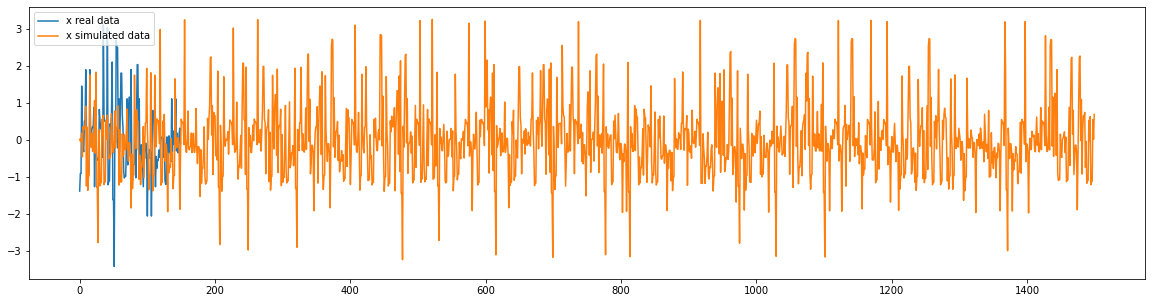

In [9]:
sample_size = x_full_scaled.shape[:][1]

sample_number = 250

x_simulated = np.empty((sample_number,sample_size))
 
for i in range(sample_number):
    x_simulated[i] = vae_mft.predict(x_full_scaled[[random.randrange(x_full_scaled.shape[0])]])

    
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(x_full_scaled.flatten(), label='x real data')
plt.plot(x_simulated.flatten(), label='x simulated data')
plt.legend(loc='upper left')
plt.show()

In [10]:
x_full = np.concatenate([x_full_scaled, x_simulated,])
print(x_full.shape)

(275, 6)


In [11]:
rev_x = scaler_vae.inverse_transform(x_full)
#rev_x = x_full
print(rev_x)

[[3.94000000e+02 3.12323800e+04 8.36000000e-01 4.92000000e+01
  4.80000000e+00 6.62000000e+02]
 [5.38000000e+02 4.49122400e+04 1.20300000e+00 5.02000000e+01
  4.80000000e+00 6.53000000e+02]
 [4.10000000e+02 3.18529000e+04 8.53000000e-01 5.02000000e+01
  4.80000000e+00 6.90000000e+02]
 ...
 [6.16546199e+02 4.62610815e+04 1.23224426e+00 4.75956434e+01
  4.66610165e+00 7.34983362e+02]
 [4.22650901e+02 2.92874817e+04 7.87850286e-01 4.71103062e+01
  4.75729382e+00 9.88115176e+02]
 [4.17498297e+02 2.90851290e+04 7.81329126e-01 4.71488332e+01
  4.76200208e+00 1.01046547e+03]]


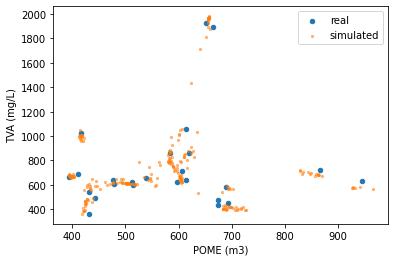

In [12]:
x_real = rev_x[0:25, 0]
y_real = rev_x[0:25, -1]
x_1 = rev_x[25:,0]
y_1 = rev_x[25:,-1]
plt.scatter(x_real,y_real, label='real', s=20)
plt.scatter(x_1, y_1, label='simulated', s=5, alpha=0.5)
plt.xlabel('POME (m3)')
plt.ylabel('TVA (mg/L)')
plt.legend()

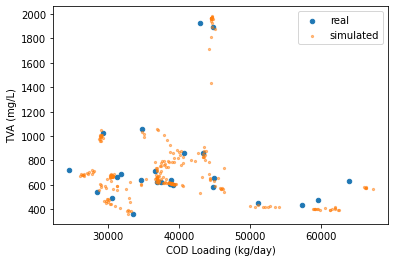

In [13]:
x_real = rev_x[0:25, 1]
y_real = rev_x[0:25, -1]
x_2 = rev_x[25:,1]
y_2 = rev_x[25:,-1]
plt.scatter(x_real,y_real, label='real', s=20)
plt.scatter(x_2, y_2, label='simulated', s=5, alpha=0.5)
plt.xlabel('COD Loading (kg/day)')
plt.ylabel('TVA (mg/L)')
plt.legend()

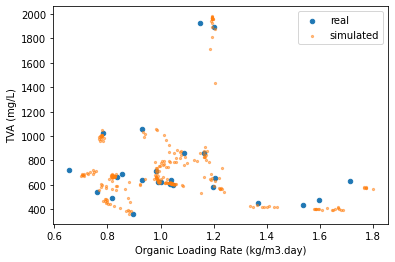

In [14]:
x_real = rev_x[0:25, 2]
y_real = rev_x[0:25, -1]
x_3 = rev_x[25:,2]
y_3 = rev_x[25:,-1]
plt.scatter(x_real,y_real, label='real', s=20)
plt.scatter(x_3, y_3, label='simulated', s=5, alpha=0.5)
plt.xlabel('Organic Loading Rate (kg/m3.day)')
plt.ylabel('TVA (mg/L)')
plt.legend()

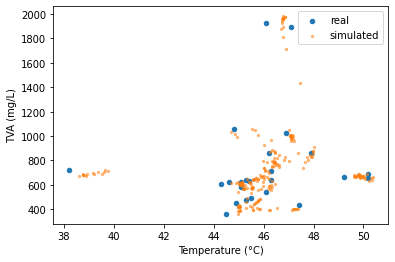

In [15]:
x_real = rev_x[0:25, 3]
y_real = rev_x[0:25, -1]
x_4 = rev_x[25:,3]
y_4 = rev_x[25:,-1]
plt.scatter(x_real,y_real, label='real', s=20)
plt.scatter(x_4, y_4, label='simulated', s=5, alpha=0.5)
plt.xlabel('Temperature (°C)')
plt.ylabel('TVA (mg/L)')
plt.legend()

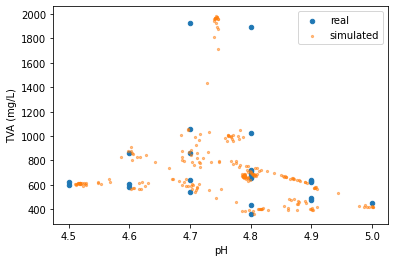

In [16]:
x_real = rev_x[0:25, 4]
y_real = rev_x[0:25, -1]
x_5 = rev_x[25:,4]
y_5 = rev_x[25:,-1]
plt.scatter(x_real,y_real, label='real', s=20)
plt.scatter(x_5, y_5, label='simulated', s=5, alpha=0.5)
plt.xlabel('pH')
plt.ylabel('TVA (mg/L)')
plt.legend()

In [21]:
print("POME")
print('real - mean :', np.mean(rev_x[0:25, 0]), 'std :', np.std(rev_x[0:25, 0]))
print('simulated - mean :', np.mean(rev_x[25:, 0]), 'std :', np.std(rev_x[25:, 0]))
print('')
print("COD")
print('real - mean :', np.mean(rev_x[0:25, 1]), 'std :', np.std(rev_x[0:25, 1]))
print('simulated - mean :', np.mean(rev_x[25:, 1]), 'std :', np.std(rev_x[25:, 1]))
print('')
print("Organic")
print('real - mean :', np.mean(rev_x[0:25, 2]), 'std :', np.std(rev_x[0:25, 2]))
print('simulated - mean :', np.mean(rev_x[25:, 2]), 'std :', np.std(rev_x[25:, 2]))
print('')
print("Temperature")
print('real - mean :', np.mean(rev_x[0:25, 3]), 'std :', np.std(rev_x[0:25, 3]))
print('simulated - mean :', np.mean(rev_x[25:, 3]), 'std :', np.std(rev_x[25:, 3]))
print('')
print("pH")
print('real - mean :', np.mean(rev_x[0:25, 4]), 'std :', np.std(rev_x[0:25, 4]))
print('simulated - mean :', np.mean(rev_x[25:, 4]), 'std :', np.std(rev_x[25:, 4]))
print('')
print("TVA")
print('real - mean :', np.mean(rev_x[0:25, -1]), 'std :', np.std(rev_x[0:25, -1]))
print('simulated - mean :', np.mean(rev_x[25:, -1]), 'std :', np.std(rev_x[25:, -1]))

POME
real - mean : 581.36 std : 135.53239612727282
simulated - mean : 573.5368895665575 std : 132.7605807977149

COD
real - mean : 39992.065599999994 std : 9647.386120555591
simulated - mean : 39164.43031859628 std : 9497.130480724434

Organic
real - mean : 1.0708799999999998 std : 0.2583910710531616
simulated - mean : 1.0487752059159552 std : 0.254352161677824

Temperature
real - mean : 45.91999999999999 std : 2.2609732417700132
simulated - mean : 46.107302214512444 std : 2.222329894390475

pH
real - mean : 4.76 std : 0.12649110640673528
simulated - mean : 4.752625726646409 std : 0.11450580237109632

TVA
real - mean : 750.4 std : 378.9808438430628
simulated - mean : 757.1993120068903 std : 368.57041476841516
